In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt  

In [8]:
image_size= 256
batch_size= 32
channels= 3
epochs= 50

In [9]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle= True,
    image_size= (image_size, image_size),
    batch_size= batch_size
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(label_batch.numpy())

(256, 256, 3)
[1 0 1 0 1 0 0 0 1 1 2 0 1 0 0 0 1 0 0 1 1 0 1 2 0 0 0 0 1 1 1 1]


In [12]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[181. 179. 192.]
  [157. 155. 168.]
  [167. 165. 178.]
  ...
  [ 88.  86.  99.]
  [ 90.  88. 101.]
  [ 96.  94. 107.]]

 [[159. 157. 170.]
  [150. 148. 161.]
  [162. 160. 173.]
  ...
  [ 87.  85.  98.]
  [ 90.  88. 101.]
  [ 96.  94. 107.]]

 [[158. 156. 169.]
  [162. 160. 173.]
  [174. 172. 185.]
  ...
  [ 99.  97. 110.]
  [ 94.  92. 105.]
  [ 94.  92. 105.]]

 ...

 [[130. 128. 141.]
  [131. 129. 142.]
  [141. 139. 152.]
  ...
  [105. 102. 111.]
  [104. 101. 110.]
  [101.  98. 107.]]

 [[125. 123. 136.]
  [123. 121. 134.]
  [150. 148. 161.]
  ...
  [104. 101. 110.]
  [105. 102. 111.]
  [108. 105. 114.]]

 [[151. 149. 162.]
  [153. 151. 164.]
  [181. 179. 192.]
  ...
  [117. 114. 123.]
  [116. 113. 122.]
  [121. 118. 127.]]], shape=(256, 256, 3), dtype=float32)


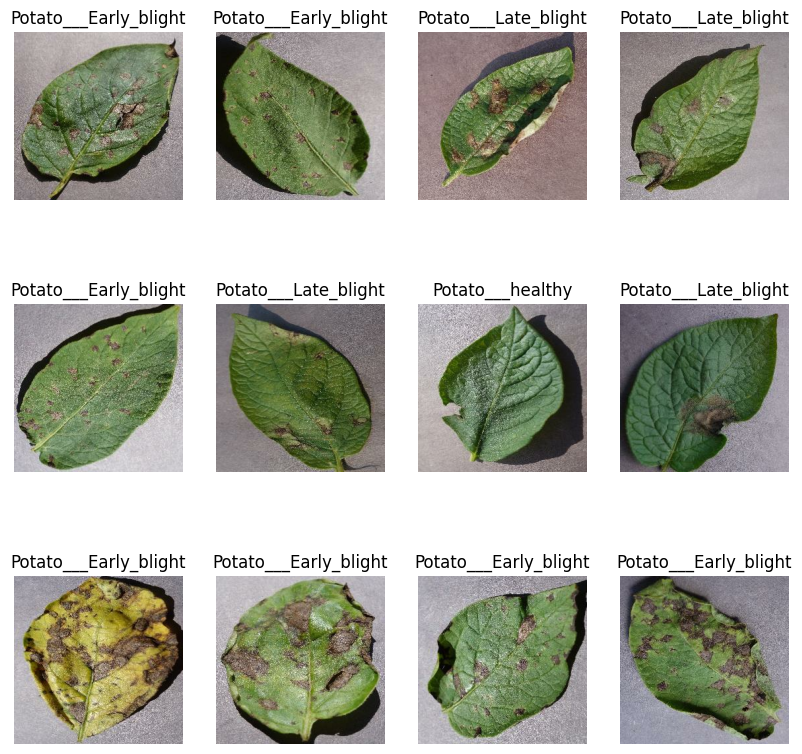

In [13]:
plt.figure(figsize= (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [14]:
len(dataset)

68

In [ ]:
80% ==> train
20% ==> 10% validation & 10% test

In [15]:
train_size= 0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds= dataset.take(54)
len(train_ds)

54

In [17]:
last_ds= dataset.skip(54)
len(last_ds)

14

In [18]:
val_size= last_ds.take(6)
len(val_size)

6

In [19]:
test_ds= last_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle= True, shuffle_size= 10000):
    
    ds_size= len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
        
    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)
    
    train_ds= ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [25]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [26]:
resize_ds= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
augmentation_ds= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
input_shape= (batch_size, image_size, image_size, channels)
n_classes= 3

model = models.Sequential([
    resize_ds,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape= input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics= ['accuracy']
)

In [31]:
history= model.fit(
    train_ds,
    epochs= epochs,
    batch_size= batch_size,
    verbose= 1,
    validation_data= val_ds
)

Epoch 1/50
54/54 [==============================] - 46s 831ms/step - loss: 0.9005 - accuracy: 0.4988 - val_loss: 0.8605 - val_accuracy: 0.5625
Epoch 2/50
54/54 [==============================] - 42s 781ms/step - loss: 0.6494 - accuracy: 0.6916 - val_loss: 0.4041 - val_accuracy: 0.8223
Epoch 3/50
54/54 [==============================] - 42s 779ms/step - loss: 0.3581 - accuracy: 0.8576 - val_loss: 0.2618 - val_accuracy: 0.9028
Epoch 4/50
54/54 [==============================] - 42s 779ms/step - loss: 0.2310 - accuracy: 0.9115 - val_loss: 0.1879 - val_accuracy: 0.9277
Epoch 5/50
54/54 [==============================] - 42s 784ms/step - loss: 0.2009 - accuracy: 0.9225 - val_loss: 0.1340 - val_accuracy: 0.9502
Epoch 6/50
54/54 [==============================] - 42s 780ms/step - loss: 0.1492 - accuracy: 0.9369 - val_loss: 0.1345 - val_accuracy: 0.9560
Epoch 7/50
54/54 [==============================] - 42s 780ms/step - loss: 0.1452 - accuracy: 0.9392 - val_loss: 0.1705 - val_accuracy: 0.9358

In [32]:
scores= model.evaluate(test_ds)

54/54 [==============================] - 9s 164ms/step - loss: 1.4534e-05 - accuracy: 1.0000


In [33]:
scores

[1.4534059118886944e-05, 1.0]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
history.history['accuracy']

[0.49884259700775146,
 0.6915509104728699,
 0.8576388955116272,
 0.9114583134651184,
 0.9224537014961243,
 0.9369212985038757,
 0.9392361044883728,
 0.9565972089767456,
 0.9693287014961243,
 0.9780092835426331,
 0.9346064925193787,
 0.9421296119689941,
 0.9774305820465088,
 0.9861111044883728,
 0.9728009104728699,
 0.9849537014961243,
 0.9953703880310059,
 0.9901620149612427,
 0.9745370149612427,
 0.9890046119689941,
 0.9803240895271301,
 0.9872685074806213,
 0.9982638955116272,
 0.9988425970077515,
 0.9994212985038757,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [39]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

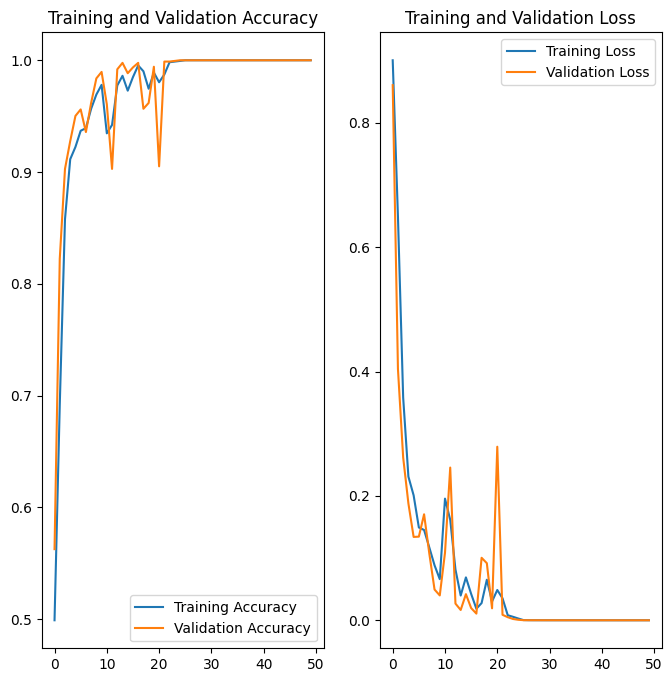

In [46]:
plt.figure(figsize= (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label= 'Training Accuracy')
plt.plot(range(epochs), val_acc, label= 'Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label= 'Training Loss')
plt.plot(range(epochs), val_loss, label= 'Validation Loss')
plt.legend(loc= 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 187ms/step
Predicted label: Potato___Late_blight


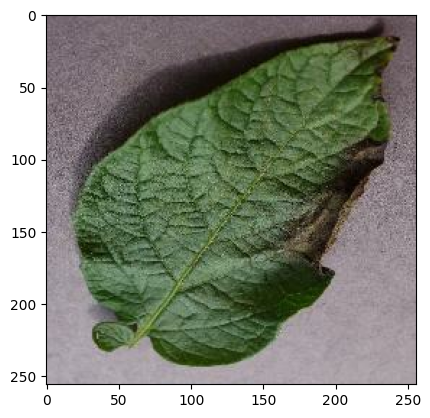

In [63]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image= images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction= model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    

In [64]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


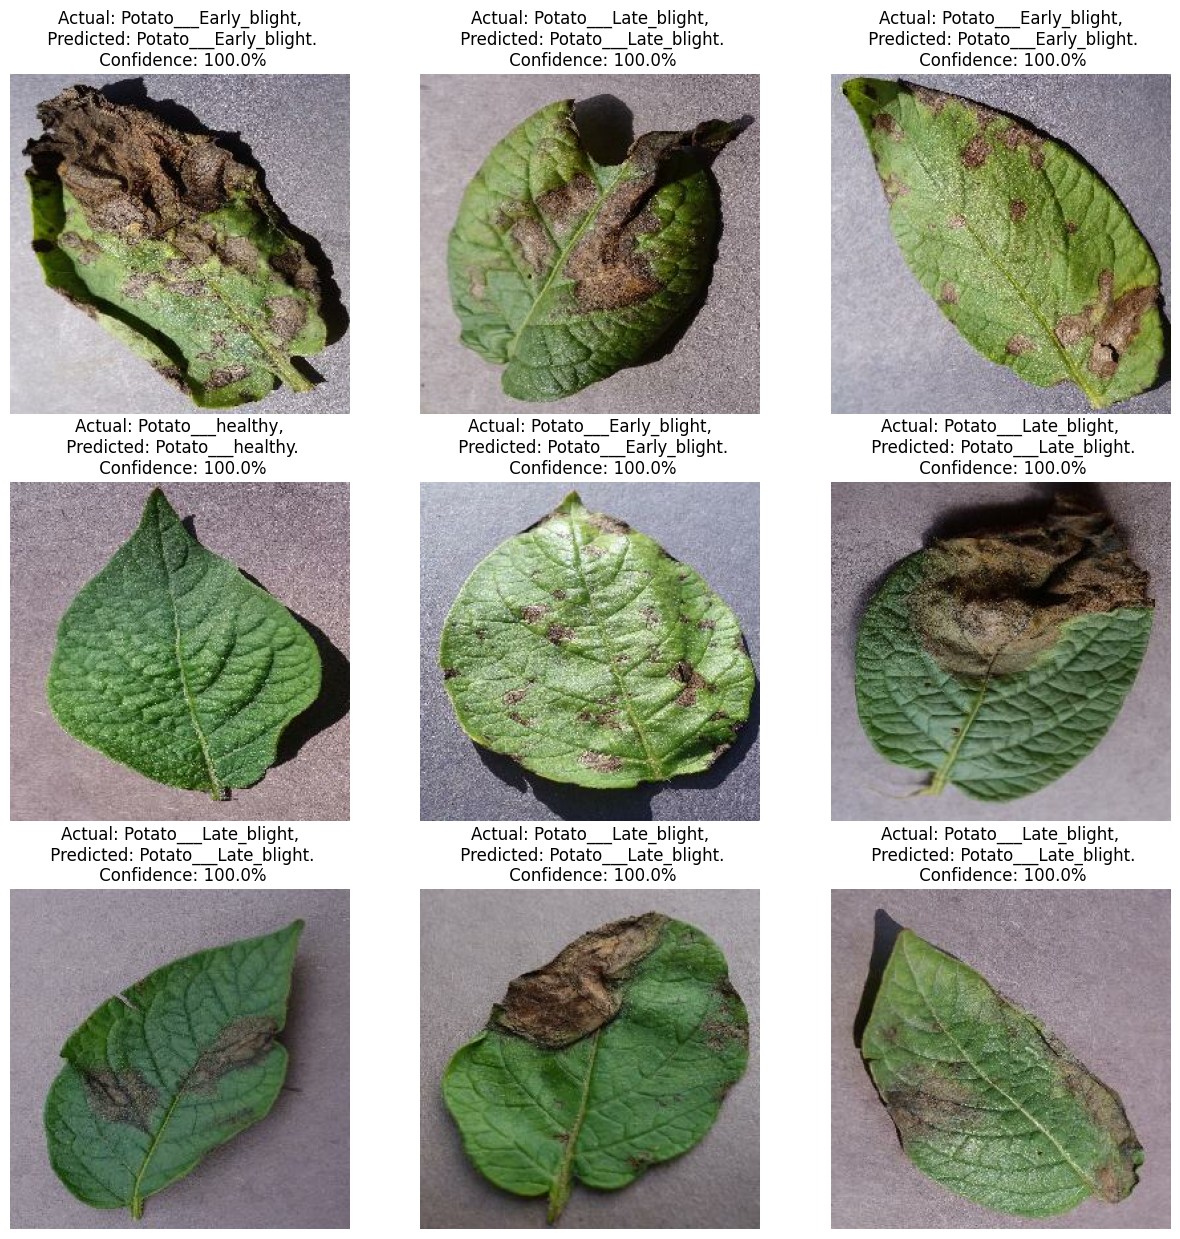

In [65]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [68]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
